## Load data

In [12]:
import numpy as np

In [13]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
datapath = '/media/sf_VBox_Shared/timeseries/UCR_WaveGesture/'
#datapath = '/media/sf_VBox_Shared/timeseries/PAMAP2_Dataset/slidingwindow500last/'

In [15]:
X_train = np.load(datapath+'X_train.npy')
y_train_binary = np.load(datapath+'y_train_binary.npy')
X_val = np.load(datapath+'X_val.npy')
y_val_binary = np.load(datapath+'y_val_binary.npy')
X_test = np.load(datapath+'X_test.npy')
y_test_binary = np.load(datapath+'y_test_binary.npy')

print(X_train.shape)

(627, 315, 3)


In [16]:
y_train_binary[:4]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [17]:
num_classes = y_train_binary.shape[1]
print(num_classes)

8


## Generate models

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam

Using Theano backend.


In [19]:
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))

from mcfly import modelgen, find_architecture

In [20]:
models = modelgen.generate_models(X_train.shape, num_classes, number_of_models = 5, model_type = None)

In [21]:
for model, params, model_types in models:
    print(params)
    model.summary()

{'filters': array([87, 77, 21, 87, 19, 99, 39, 43]), 'fc_hidden_nodes': 60, 'regularization_rate': 0.0014501313228980734, 'learning_rate': 0.004202668802392339}
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution1d_1 (Convolution1D)  (None, 315, 87)       870         convolution1d_input_1[0][0]      
____________________________________________________________________________________________________
convolution1d_2 (Convolution1D)  (None, 315, 77)       20174       convolution1d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 315, 77)       0           convolution1d_2[0][0]            
____________________________________________________________________________________________________
convolution1d_3 (Convolution1D)

## Compare models

In [22]:
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models)

Train on 100 samples, validate on 269 samples
Epoch 1/5
100/100 [==============================] - 3s - loss: 2.1927 - acc: 0.1100 - val_loss: 2.0770 - val_acc: 0.1413
Epoch 2/5
100/100 [==============================] - 3s - loss: 2.1174 - acc: 0.1300 - val_loss: 2.0833 - val_acc: 0.1413
Epoch 3/5
100/100 [==============================] - 3s - loss: 2.0819 - acc: 0.1700 - val_loss: 2.0792 - val_acc: 0.1413
Epoch 4/5
100/100 [==============================] - 3s - loss: 2.0752 - acc: 0.1300 - val_loss: 2.0825 - val_acc: 0.1152
Epoch 5/5
100/100 [==============================] - 3s - loss: 2.0731 - acc: 0.1100 - val_loss: 2.0788 - val_acc: 0.1413
Train on 100 samples, validate on 269 samples
Epoch 1/5
100/100 [==============================] - 5s - loss: 2.2795 - acc: 0.1300 - val_loss: 2.0755 - val_acc: 0.1152
Epoch 2/5
100/100 [==============================] - 5s - loss: 2.2402 - acc: 0.2300 - val_loss: 2.0674 - val_acc: 0.1747
Epoch 3/5
100/100 [==============================] - 5

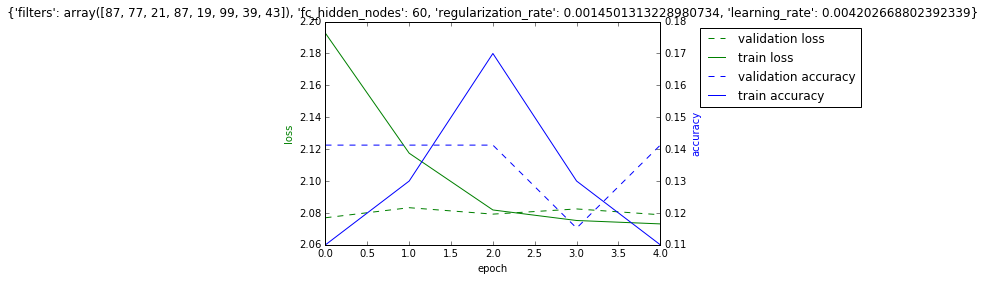

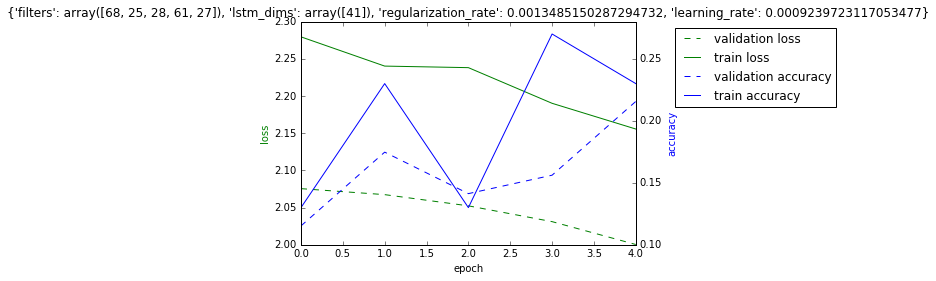

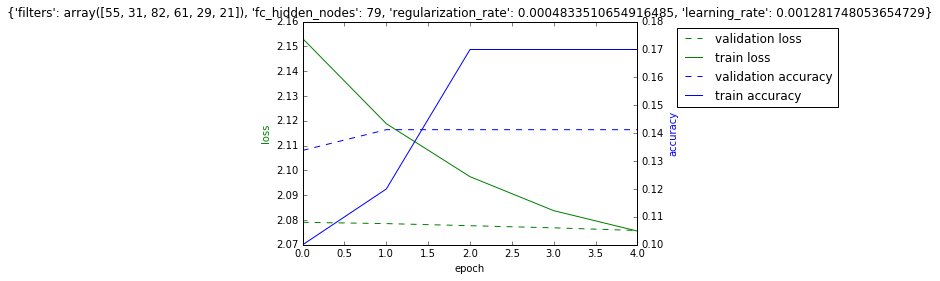

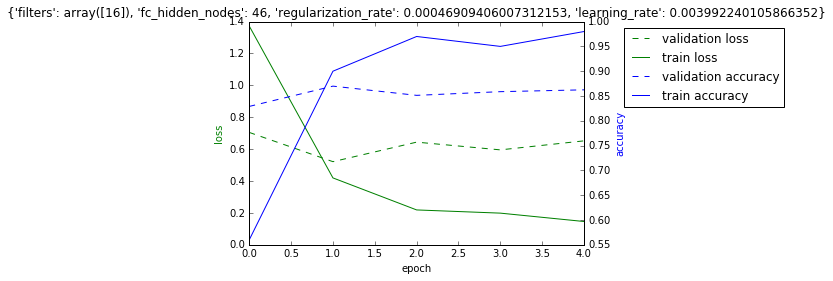

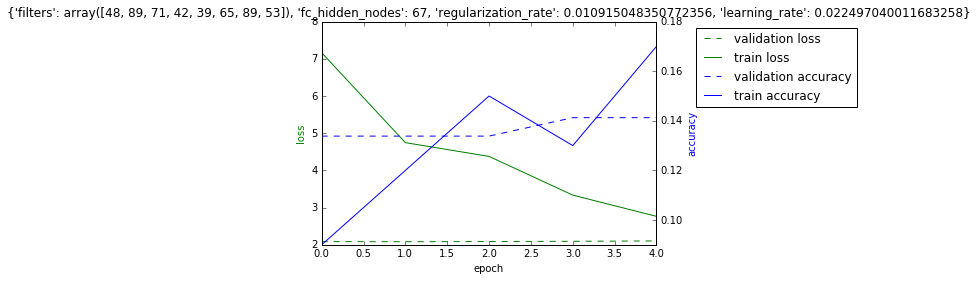

In [23]:
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)

In [24]:
import pandas as pd

results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'filters': array([87, 77, 21, 87, 19, 99, 39,...",0.11,2.073113,0.141264,2.078848
1,"{'filters': array([68, 25, 28, 61, 27]), 'lstm...",0.23,2.155616,0.215613,2.000402
2,"{'filters': array([55, 31, 82, 61, 29, 21]), '...",0.17,2.075538,0.141264,2.075775
3,"{'filters': array([16]), 'fc_hidden_nodes': 46...",0.98,0.146148,0.862454,0.652001
4,"{'filters': array([48, 89, 71, 42, 39, 65, 89,...",0.17,2.764920,0.141264,2.104241


## Or do it in one command

In [ ]:
best_model, best_params, best_model_type, kNN = find_architecture.find_best_architecture(
    X_train, y_train_binary, X_val, y_val_binary, verbose=True, number_of_models=5)

## Train the best model for real

In [25]:
best_model_index = np.argmax(val_accuracies)
#best_model_index = 3

In [26]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

3 CNN {'filters': array([16]), 'fc_hidden_nodes': 46, 'regularization_rate': 0.00046909406007312153, 'learning_rate': 0.003992240105866352}


In [27]:
best_model.predict_proba(X_val)

/home/dafne/anaconda2/envs/mcfly/lib/python3.5/site-packages/keras/backend/theano_backend.py:527: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: keras_learning_phase.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  **kwargs)


269/269 [==============================] - 0s     


array([[  9.99823570e-01,   4.64210956e-07,   3.86239502e-14, ...,
          1.75931098e-04,   3.08907039e-10,   3.61421440e-12],
       [  1.50565658e-08,   1.25596400e-11,   9.99999940e-01, ...,
          8.21480420e-15,   1.78737718e-08,   3.58524365e-12],
       [  1.64119465e-11,   7.44769135e-15,   1.00000000e+00, ...,
          3.31362169e-19,   3.34757400e-09,   3.77561633e-15],
       ..., 
       [  1.72901596e-03,   2.41787624e-04,   9.42339175e-12, ...,
          9.93660092e-01,   2.49817020e-08,   4.58689584e-08],
       [  1.47535745e-02,   7.99367391e-03,   3.62169776e-05, ...,
          9.73167896e-01,   7.11986729e-07,   3.43100874e-05],
       [  1.04921352e-08,   9.99998808e-01,   8.54015816e-12, ...,
          1.22116241e-11,   1.19983008e-06,   4.27330782e-10]])

In [ ]:
nr_epochs = 10
datasize = X_train.shape[0]#1000
history = best_model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary))

In [ ]:
find_architecture.plotTrainingProcess(history)

## Test on Testset

In [ ]:
score_test = best_model.evaluate(X_test, y_test_binary, verbose=False)
print('Score of best model: ' + str(score_test))

In [ ]:
best_model.get_config()[0]